In [2]:
import collections
import tqdm
import copy
from IPython import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import numpy as np
import jax.numpy as jnp
import optax
import jax

In [3]:
size = 5
gamma = 0.9

num_observations = 4
num_actions = 4

def step(s, a):
    if s == 0 and a == 1:
        next_s = 1
    elif s == 0 and a == 2:
        next_s = 2
    elif s == 0 and a == 3:
        next_s = 3
    else:
        next_s = s

    return next_s

In [4]:
dataset_size = 1_000
num_trajectories = 100
max_episode_lengths = 10 + 1

assert num_trajectories * (max_episode_lengths - 1) == dataset_size

traj_dataset = collections.defaultdict(list)
for traj_idx in range(num_trajectories):
    # random sample initial observations
    obs = 0
    for t in range(max_episode_lengths):
        action = np.random.choice(num_actions)

        next_obs = step(obs, action)
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['terminals'].append((t == max_episode_lengths - 1))
        
        obs = next_obs

for k, v in traj_dataset.items():
    if k in ['observations', 'actions']:
        traj_dataset[k] = np.array(v, dtype=np.int32)
    # elif k in ['terminals']:
    #     traj_dataset[k] = np.array(v, dtype=bool)
    else:
        traj_dataset[k] = np.array(v, dtype=np.float32)

masks = (traj_dataset['terminals'] == 0)
# next_masks = (np.concatenate([[1.0], traj_dataset['terminals'][:-1]]) == 0)
next_masks = np.concatenate([[False], masks[:-1]])
new_terminals = np.concatenate([traj_dataset['terminals'][1:], [1.0]])

dataset = dict(
    observations=traj_dataset['observations'][masks],
    actions=traj_dataset['actions'][masks],
    next_observations=traj_dataset['observations'][next_masks],
    next_actions=traj_dataset['actions'][next_masks],
    terminals=new_terminals[masks],
)

for k, v in dataset.items():
    assert len(v) == dataset_size

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 374.28it/s]


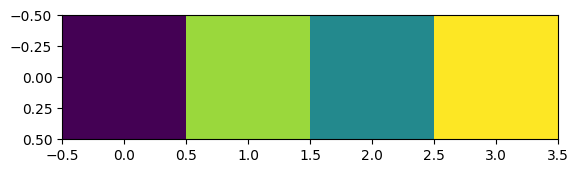

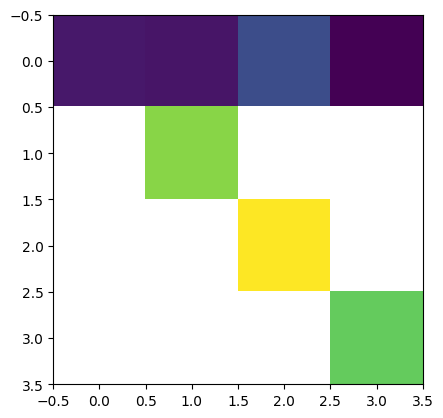

In [9]:
# (chongyi): this is not correct now
# compute the true empirical discounted state occupancy measure
# d = [[] for _ in range(num_observations)]
# sr = jax.nn.one_hot(dataset['observations'][-1], size * size)
# for t in tqdm.trange(dataset_size - 1, -1, -1):
#     d[dataset['observations'][t]] = d[dataset['observations'][t]] + [sr]
#     sr = gamma * sr + (1 - gamma) * jax.nn.one_hot(dataset['observations'][t], size*size)
# SR = np.array([np.mean(sr_vec, axis=0) for sr_vec in d])
# plt.imshow(SR)
# plt.show()

# compute the true discounted state occupancy measure
beta = np.ones([num_observations, num_actions])
beta /= num_actions
transition_probs_sa = np.zeros([num_observations, num_actions, num_observations])
for obs in range(num_observations):
    for action in range(num_actions):
        next_obs = step(obs, action)
        transition_probs_sa[obs, action, next_obs] += 1
transition_probs_sa = transition_probs_sa / np.sum(transition_probs_sa, axis=-1, keepdims=True)
transition_probs_s = np.sum(transition_probs_sa * beta[..., None], axis=1)
transition_probs_sa = jnp.array(transition_probs_sa)
transition_probs_s = jnp.array(transition_probs_s)

sr_sa = jnp.zeros([num_observations, num_actions, num_observations])
sr_s = jnp.zeros([num_observations, num_observations])
for _ in tqdm.trange(1000):
    sr_s = (1 - gamma) * jnp.eye(num_observations) + gamma * jnp.einsum('ij,jk->ik', transition_probs_s, sr_s)
    sr_sa = (1 - gamma) * jnp.eye(num_observations)[:, None] + gamma * jnp.einsum(
        'ijk,kl->ijl',
        transition_probs_sa,
        jnp.sum(beta[..., None] * sr_sa, axis=1)
    )

counts = collections.Counter(dataset['observations'])
marginal_s_beta = np.array([counts[obs] for obs in range(num_observations)])
marginal_s_beta = marginal_s_beta / np.sum(marginal_s_beta)
marginal_s_beta = jnp.array(marginal_s_beta)
plt.imshow(marginal_s_beta.reshape((1, num_observations)))
plt.show()

log_ratios = jnp.log(sr_s / marginal_s_beta[None])
plt.imshow(log_ratios)
plt.show()

### Pretrain FB representations.

In [ ]:
def plot_metrics(metrics, f_axes=None, logyscale_stats=[], title='', label=None):
  # learning curves
  if f_axes is None:
    nrows = np.ceil(len(metrics) / 4).astype(int)
    ncols = 4
    f, axes = plt.subplots(nrows=nrows, ncols=ncols)
    if nrows == 1:
        axes = np.array([axes])
    f.set_figheight(3 * nrows)
    f.set_figwidth(3 * ncols)
  else:
    f, axes = f_axes

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y, label=label)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)
    
    # ax.legend()
    ax.grid()

  f.suptitle(title)

  return f, axes

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:06<00:00, 1429.70it/s]
/tmp/ipykernel_3316379/622352385.py:205: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


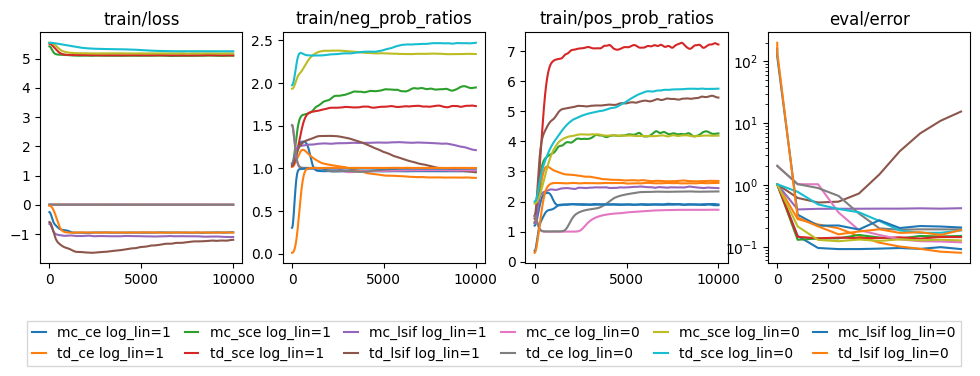

In [ ]:
# learn the representations
repr_dim = 3
batch_size = 256

(terminal_locs,) = np.nonzero(dataset['terminals'] > 0)

def get_data(batch_size):
    idxs = np.random.randint(dataset_size, size=(batch_size,))
    rand_idxs = np.random.randint(dataset_size, size=(batch_size,))
    
    offsets = np.random.geometric(p=1 - gamma, size=(batch_size,)) - 1  # in [0, inf)
    final_state_idxs = terminal_locs[np.searchsorted(terminal_locs, idxs)]
    future_idxs = np.minimum(idxs + offsets, final_state_idxs)
    
    batch = dict(
        observations=dataset['observations'][idxs],
        actions=dataset['actions'][idxs], 
        next_observations=dataset['next_observations'][idxs],
        next_actions=dataset['next_actions'][idxs],
        future_observations=dataset['observations'][future_idxs],
        random_observations=dataset['observations'][rand_idxs],
    )
    
    return batch

def get_prob_ratios(f, b, repr_activation=False, log_linear=False):
    if repr_activation:
        f = jax.nn.softplus(f)
        b = jax.nn.softplus(b)
    prob_ratios = jnp.einsum('ik,jk->ij', f, b)
    if log_linear:
        prob_ratios = jnp.exp(prob_ratios)
    return prob_ratios

def evaluate_fn(params, batch, repr_activation=False, log_linear=False):
    # compute the error
    f = params[0]
    b = params[1]
    # random_b = params[1][batch['random_observations']]
    log_ratio_preds = jnp.log(get_prob_ratios(f, b, repr_activation, log_linear))
    # if 'sce' in loss_type:
    #     # log_ratio_preds = jax.nn.log_softmax(log_ratio_preds, axis=1) + jnp.log(num_observations)  # This only works if dataset coverage is uniform
        
    #     random_log_ratios = jnp.log(get_prob_ratios(f, random_b, repr_activation, log_linear))
    #     log_ratio_preds = log_ratio_preds - jax.nn.logsumexp(random_log_ratios, axis=-1)[:, None] + jnp.log(batch_size)
    error = np.nanmean((log_ratio_preds - log_ratios) ** 2)
    
    info = dict(
        error=error,
    )
    
    return info

def train_and_eval(repr_dim, loss_type, log_linear, num_training_steps=10_000, eval_interval=1_000):
    repr_activation = False
    # if loss_type in ['mc_ce', 'mc_sce', 'td_ce', 'td_sce'] and not log_linear:
    #     # If we want to use the linear parametrization with the CE or softmax CE loss,
    #     # we apply an elementwise activation to the reps so that the dot product is positive.
    #     # For the LSIF loss, it's fine if the dot product is neg.
    #     repr_activation = True

    rng = jax.random.key(np.random.randint(2 ** 32))
    rng, f_rng, b_rng = jax.random.split(rng, 3)
    F = 1e-6 * jax.random.normal(f_rng, shape=(num_observations, repr_dim))
    B = 1e-6 * jax.random.normal(b_rng, shape=(num_observations, repr_dim))
    params = (F, B)
    
    optimizer = optax.adam(learning_rate=3e-3)
    opt_state = optimizer.init(params)
    
    @jax.jit
    def loss_fn(params, batch, rng):
        obs = batch['observations']
        actions = batch['actions']
        next_obs = batch['next_observations']
        future_obs = batch['future_observations']
        random_obs = batch['random_observations']
        
        I = jnp.eye(batch_size)
        f = params[0][obs]
        next_f = params[0][next_obs]
        current_b = params[1][obs]
        future_b = params[1][future_obs]
        random_b = params[1][random_obs]
        
        current_prob_ratios = get_prob_ratios(f, current_b, repr_activation, log_linear)
        future_prob_ratios = get_prob_ratios(f, future_b, repr_activation, log_linear)
        random_prob_ratios = get_prob_ratios(f, random_b, repr_activation, log_linear)
        
        # if loss_type in ['mc_ce', 'mc_sce', 'mc_lsif']:
        #     prob_ratios = I * future_prob_ratios + (1 - I) * random_prob_ratios
        #     if loss_type == 'mc_ce': # binary cross entropy
        #         mask = I + (1 - I) / (batch_size - 1)
        #         loss = mask * optax.sigmoid_binary_cross_entropy(logits=jnp.log(prob_ratios), labels=I)
        #     elif loss_type == 'mc_sce':  # softmax cross entropy
        #         loss = (optax.softmax_cross_entropy(logits=jnp.log(prob_ratios), labels=I) + optax.softmax_cross_entropy(logits=jnp.log(prob_ratios.T), labels=I)) / 2.0
        #     elif loss_type == 'mc_lsif': # least square importance filtering
        #         loss = 0.5 * ((1 - I) * prob_ratios**2).sum() / (1 - I).sum() - (I * prob_ratios).sum() / I.sum()
        #     else:
        #         raise NotImplementedError
        # elif loss_type in ['td_ce', 'td_sce', 'td_lsif']:
        #     if loss_type == 'td_ce':
        #         prob_ratios = I * current_prob_ratios + (1 - I) * random_prob_ratios
                
        #         weight_log_prob_ratios = jnp.log(get_prob_ratios(next_f, random_b, repr_activation, log_linear))
        #         w = jnp.exp(weight_log_prob_ratios)
        #         w = jax.lax.stop_gradient(w)
                
        #         mask1 = (1 - gamma) * I + (1 - I) / (batch_size - 1)
        #         mask2 = gamma * (1 - I) * w / (batch_size - 1)
        #         loss = mask1 * optax.sigmoid_binary_cross_entropy(logits=jnp.log(prob_ratios), labels=I) + mask2 * optax.sigmoid_binary_cross_entropy(logits=jnp.log(random_prob_ratios), labels=(1 - I))
        #     elif loss_type == 'td_sce':
        #         prob_ratios = I * current_prob_ratios + (1 - I) * random_prob_ratios
                
        #         weight_log_prob_ratios = jnp.log(get_prob_ratios(next_f, random_b, repr_activation, log_linear))
        #         w = jax.nn.softmax(weight_log_prob_ratios, axis=-1)
        #         w = jax.lax.stop_gradient(w)
                
        #         loss = (1 - gamma) * optax.softmax_cross_entropy(logits=jnp.log(prob_ratios), labels=I) + gamma * optax.softmax_cross_entropy(logits=jnp.log(random_prob_ratios), labels=w)
        #     elif loss_type == 'td_lsif':
        #         prob_ratios = I * current_prob_ratios + (1 - I) * random_prob_ratios
                
        #         w = get_prob_ratios(next_f, random_b, repr_activation, log_linear)
        #         w = jax.lax.stop_gradient(w)
                
        #         loss = 0.5 * ((1 - I) * prob_ratios ** 2).sum() / (1 - I).sum() - (1 - gamma) * (I * prob_ratios).sum() / I.sum() - gamma * ((1 - I) * w * prob_ratios).sum() / (1 - I).sum()
        # else:
        #     raise NotImplementedError
        
        # implement the FB loss
        
        loss = loss.mean()
        
        info = dict(
            loss=loss,
            pos_prob_ratios=jnp.mean(jnp.diag(prob_ratios)),
            neg_prob_ratios=jnp.sum(prob_ratios * (1 - I)) / jnp.sum(1 - I),
        )
        
        return loss, info
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    
    @jax.jit
    def update_fn(params, opt_state, batch, rng):
        # key, rng = jax.random.split(key, 2)
        rng, loss_rng = jax.random.split(rng, 2)
        # batch = get_data(batch_size)
        
        (_, info), grad = grad_fn(params, batch, loss_rng)
        updates, opt_state = optimizer.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        
        return params, opt_state, rng, info
    
    metrics = collections.defaultdict(list)
    for step in tqdm.trange(num_training_steps):
        rng, update_rng = jax.random.split(rng)
        batch = get_data(batch_size)
        params, opt_state, rng, info = update_fn(params, opt_state, batch, update_rng)
        
        for k, v in info.items():
            metrics['train/' + k].append(
                np.array([step, v])
            )
        
        if step == 1 or step % eval_interval == 0:
            eval_info = evaluate_fn(params, batch, repr_activation, log_linear)
            for k, v in eval_info.items():
                metrics['eval/' + k].append(
                    np.array([step, v])
                )

        # if step == 1 or step % plot_interval == 0:
        #     label = loss_type + ' log_linear={}'.format(log_linear)
        #     f = plot_metrics(metrics, logyscale_stats=[], label=label)
        #     display.clear_output(wait=True)
        #     f.tight_layout()
        #     f.show()

    for k, v in metrics.items():
        metrics[k] = np.asarray(v)

    return metrics

loss_type_vec = ['mc_ce', 'td_ce', 'mc_sce', 'td_sce', 'mc_lsif', 'td_lsif']
# loss_type_vec = ['mc_ce']

all_metrics = dict()
f_axes = None
for col, log_linear in enumerate([True, False]):
    
    for loss_type in loss_type_vec:
        metrics = train_and_eval(repr_dim, loss_type, log_linear)
        
        label = loss_type + ' log_lin={}'.format(int(log_linear))
        all_metrics[label] = metrics
        
        f_axes = plot_metrics(metrics, f_axes=f_axes, logyscale_stats=['eval/error'], label=label)
f, axes = f_axes

legend = axes[0, 0].legend(bbox_to_anchor=(-0.1, -0.22),
                           loc="upper left", labelspacing=0.5, columnspacing=1.0, fancybox=False,
                           shadow=False, fontsize=10, borderpad=0.35, handlelength=1.0, ncol=6)

f.tight_layout()
f.savefig("figures/mc_td_fb_lc.png", bbox_extra_artists=(legend, ))
plt.show()

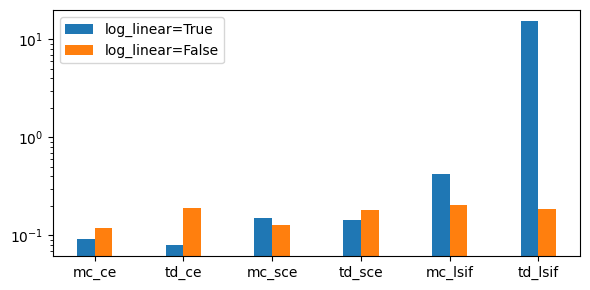

In [28]:
final_errors = collections.defaultdict(list)

f, ax = plt.subplots(nrows=1, ncols=1)
f.set_figheight(3)
f.set_figwidth(6)

x = np.arange(6)
width = 0.2
for col, log_linear in enumerate([True, False]):
    for loss_type in loss_type_vec:
        label = loss_type + ' log_lin={}'.format(int(log_linear))
        
        final_error = all_metrics[label]['eval/error'][-1, 1]
        final_errors['log_lin={}'.format(log_linear)].append(final_error)
        
    ax.bar(x - width / 2 if col == 0 else x + width / 2,
           final_errors['log_lin={}'.format(log_linear)], width=width, label='log_linear=%s' % log_linear)
    ax.set_xticks(x, loss_type_vec)
    ax.set_yscale('log')
    ax.legend()

f.tight_layout()
f.savefig("figures/mc_td_fb.png")
plt.show()